In [24]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
import optax as ox
from jax.scipy.linalg import cho_factor, cho_solve
import numpy as np

plt.style.use("style.mplstyle")
cols = plt.rcParams["axes.prop_cycle"].by_key()["color"]
key = jr.PRNGKey(123)

## Kernels

For a variance $\sigma^2$ and lengthscale $\ell$, we can write the squared exponential kernel as

$$
k(x, x') =
\sigma^2 \exp\left(\frac{-0.5\lVert x - x' \rVert_2^2}{\ell^2}\right) .
\tag{1}
$$

The corresponding JAX implementation of this is given by


In [36]:
def rbf_kernel(x, y, params):
    ell, sigma = params["lengthscale"], params["variance"]
    tau = jnp.sum(jnp.square(x / ell - y / ell))
    return sigma * jnp.exp(-0.5 * tau)


x1 = jnp.array(2.0)
x2 = jnp.array(0.9)
params = {"lengthscale": jnp.array(1.0), "variance": jnp.array(0.5)}
rbf_kernel(x1, x2, params)

Array(0.27303721, dtype=float64)

Similarly, the Matern 1/2 kernel is given by

$$
k(x, x') = \sigma^2\exp\Bigg(-\frac{\lvert x-x' \rvert}{\ell^2}\Bigg). \tag{2}
$$

## Exercise 1

Implement the Matérn 1/2 kernel from (2) in JAX.


In [37]:
# Answer Here
def matern12_kernel(x, y, params):
    pass

Check:


In [38]:
np.testing.assert_almost_equal(matern12_kernel(x1, x2, params), jnp.array(0.16643554))

## Computing the covariance

For a set of $N$ data points, the covariance matrix is an $N\times N$ matrix $\mathbf{K}$ that is given by evaluating the kernel function pairwise on all inputs i.e.,

$$
\left[\mathbf{K} \right]_{ij} = k(x_i, x_j)\,, \quad \text{for} \ i,j \in 1,2,\ldots, N.
$$

In regular Python, we may be tempted to implement this using for-loops i.e.,

```
K = np.zeros(N, N)
for i in range(N):
    for j in range(N):
        K[i, j] = kernel_fn(x[i], x[j])
```

However, such operations are generally avoided in JAX and we should instead use `vmap` ([documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html)).

## Exercise 2

Write a function to compute the covariance matrix using the below function signature. Hint, you will need two vmaps.


In [39]:
N = 100
X = jnp.sort(jr.uniform(key, shape=(N, 1), minval=-3.0, maxval=3), axis=0)


def evaluate_kernel(kernel_fn, x, y, params):
    pass

## Sampling from the GP

With a covariance function now computed, we may sample from the GP prior. The below figure shows 20 samples from a GP prior where the GP is parameterised by and RBF kernel with lengthscale 1., and variance 0.5.


In [40]:
def stabilise_covariance(K, jitter):
    N = K.shape[0]
    eye = jnp.eye(N)
    jitter_matrix = eye * jitter
    return K + jitter_matrix

[Text(0.5, 0, '$x$'), Text(0, 0.5, '$p(f(x))$')]

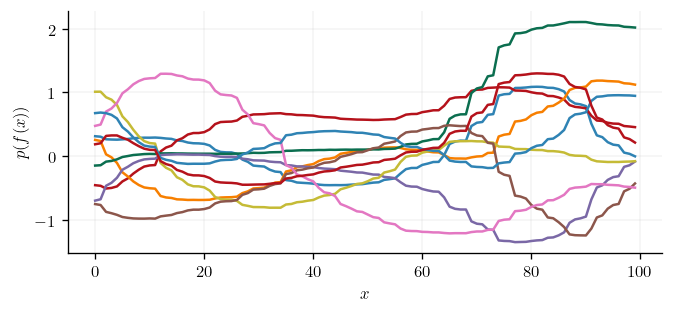

In [43]:
k = evaluate_kernel(rbf_kernel, X, X, params)
mu = jnp.zeros(N)
dist = tfp.distributions.MultivariateNormalTriL(
    mu, jnp.linalg.cholesky(stabilise_covariance(k))
)
samples = dist.sample(seed=key, sample_shape=(10)).T

fig, ax = plt.subplots()
ax.plot(samples)
ax.set(xlabel="$x$", ylabel=r"$p(f(x))$")

## Exercise 3

Recreate the above figure using your Matern kernel. What do you notice about the samples?


## Conditioning a GP

Now that we've defined a GP prior, let's condition on some data and compute the posterior distribution.


In [32]:
def predict(x, y, params):
    n = x.shape[0]
    Kxx = evaluate_kernel(rbf_kernel, x, x, params["kernel"])
    Kxx += jnp.eye(n) * params["likelihood"]["obs_noise"]
    prior_mean = jnp.zeros_like(x)
    L = cho_factor(Kxx, lower=True)
    prior_distance = y - prior_mean
    weights = cho_solve(L, prior_distance)

    def mean_and_variance(test_points):
        Kfx = evaluate_kernel(rbf_kernel, x, test_points, params["kernel"])
        mu = jnp.dot(Kfx.T, weights)
        Kxx = evaluate_kernel(rbf_kernel, test_points, test_points, params["kernel"])
        latents = cho_solve(L, Kfx)
        return mu, Kxx - jnp.dot(Kfx.T, latents)

    return mean_and_variance

Let us now extend our parameters and compute the conditional mean and (co)variance


In [33]:
true_obs_noise = 0.25

params = {
    "kernel": {"lengthscale": jnp.array(0.25), "variance": jnp.array(0.5)},
    "likelihood": {"obs_noise": jnp.array(1.0)},
}


true_f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
y = true_f(X)
y += jr.normal(key, shape=y.shape) * true_obs_noise

x_test = jnp.linspace(-3.2, 3.2, num=300)[:, None]
y_test = true_f(x_test)
mu, sigma2 = predict(X, y, params)(x_test)

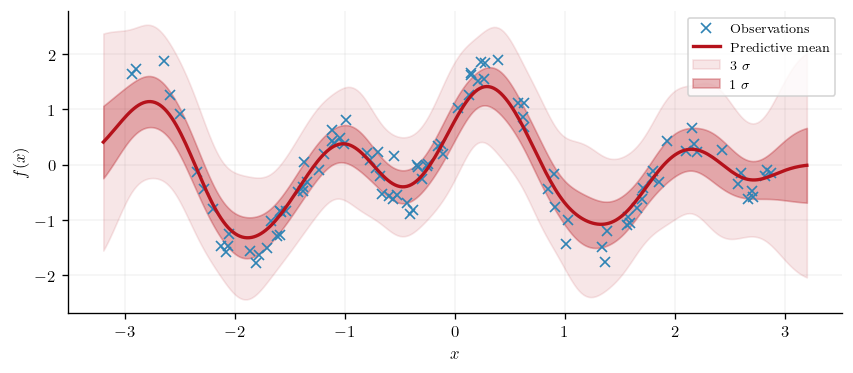

In [34]:
def plot_conditional(x_train, y_train, x_test, mu, sigma2, ax=None, legend=False):
    cols = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    if not ax:
        fig, ax = plt.subplots(figsize=(7, 3))
    ax.plot(x_train, y_train, "x", label="Observations", color=cols[0])
    ax.plot(x_test, mu, label="Predictive mean", linewidth=2, color=cols[1])
    ax.fill_between(
        x_test.squeeze(),
        mu.squeeze() - 3 * jnp.sqrt(jnp.diag(sigma2).squeeze()),
        mu.squeeze() + 3 * jnp.sqrt(jnp.diag(sigma2).squeeze()),
        alpha=0.1,
        color=cols[1],
        label=r"3 $\sigma$",
    )
    ax.fill_between(
        x_test.squeeze(),
        mu.squeeze() - jnp.sqrt(jnp.diag(sigma2).squeeze()),
        mu.squeeze() + jnp.sqrt(jnp.diag(sigma2).squeeze()),
        alpha=0.3,
        color=cols[1],
        label=r"1 $\sigma$",
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")
    return ax


ax = plot_conditional(X, y, x_test, mu, sigma2)
ax.legend(loc="best")

## Exercise 4

Experiment with different values for the parameters defined above. What effect does this have on the conditional mean and variance?


## Optimising the Hyperparameter

From your solution to Exercise 4, you can see that the fidelity between the observed data and the conditional distribution varies with the parameters' values. However, identifying the _optimal_ value through grid search is not a scalable solution and we seek to instead obtain Type-II MLEs. We do this through gradient-based optimisation.

Each of the three parameters considered here are strictly positive. Because of this, there is a danger when optimising them that we could step too far and arrive at a negative value. For this reason, we transform our parameters so that they are defined on the entire real line, make an optimisation step, and then back-transform the parameter value so that they are re-defined on their original constrained space. We therefore require that our function is bijective i.e., has a one-to-one mapping, so that the transforming and back-transforming steps are fully identifiable. This is easily achieved with JAX's `tree_map` function.


In [ ]:
softplus = lambda x: jnp.log(1.0 + jnp.exp(x))
inv_softplus = lambda x: jnp.log(jnp.exp(x) - 1.0)

unconstrained_params = jax.tree_map(inv_softplus, params)
print(unconstrained_params)

{'kernel': {'lengthscale': Array(0.54132485, dtype=float64, weak_type=True), 'variance': Array(0.54132485, dtype=float64, weak_type=True)}, 'likelihood': {'obs_noise': Array(0.54132485, dtype=float64, weak_type=True)}}


With parameters now defined on the entire real line, we’ll now go ahead and define our GP’s marginal log-likelihood function.


In [ ]:
def marginal_log_likelihood(x, y):
    n = x.shape[0]
    mu = jnp.zeros(shape=x.shape[0])

    def objective(params, jitter_amount):
        params = jax.tree_map(softplus, params)
        Kff = evaluate_kernel(rbf_kernel, x, x, params["kernel"])
        noise_matrix = jnp.eye(n) * params["likelihood"]["obs_noise"]
        gram_matrix = Kff + noise_matrix + jnp.eye(n) * jitter_amount
        L = jnp.linalg.cholesky(gram_matrix)
        return (
            jnp.array(-1.0)
            * tfp.distributions.MultivariateNormalTriL(mu, L)
            .log_prob(y.squeeze())
            .sum()
        )

    return objective

In the above function, one can see that we use TensorFlow Probability to evaluate the log-probability density function of a multivariate normal distribution. This is by no means a requirement, and one can certainly define their own log-pdf, however, this is a nice point to show how TensorFlow Porbability can be seamlessly integrated into Jax code.

## Exercise 5

Compute the gradient of the marginal log-likelihood function and evaluate it for your current unconstrained set of parameters.


## Exercise 6

We'll want to evaluate the MLL multiple times during our optimisation. In such cases, it is advantageous to JIT compile the function. JIT compile your MLL function using JAX's `jit` function and compare the runtimes with and without jitting using the `%timeit` magic command. Note - you will need to use the `block_until_ready()` function to get accurate timings e.g.,

```{py}
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = random.normal(key, (1000000,))
%timeit selu(x).block_until_ready()
```


Happy that we may differentiate and compile our MLL, let's now perform optimisation against it.


In [ ]:
params = {
    "kernel": {"lengthscale": jnp.array(1), "variance": jnp.array(1)},
    "likelihood": {"obs_noise": jnp.array(1.0)},
}
params = jax.tree_map(inv_softplus, params)

optimizer = ox.adam(learning_rate=0.05)
opt_state = optimizer.init(params)

mll = marginal_log_likelihood(X, y)

for _ in range(500):
    grads = jax.grad(mll)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = ox.apply_updates(params, updates)

In [ ]:
mle_params = jax.tree_map(softplus, params)

{'kernel': {'lengthscale': Array(0.46292848, dtype=float64),
  'variance': Array(1.46747712, dtype=float64)},
 'likelihood': {'obs_noise': Array(0.04353514, dtype=float64)}}

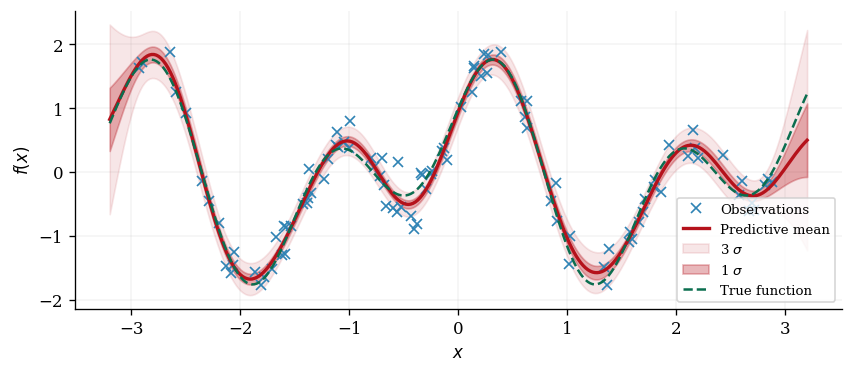

In [ ]:
mu, sigma = predict(X, y, mle_params)(x_test)

ax = plot_conditional(X, y, x_test, mu, sigma)
ax.plot(x_test, true_f(x_test), label="True function", color=cols[3], linestyle="--")
ax.legend(loc="best")